In [0]:
import torch
import torchvision
from model.abp_sc import ABPSC
from datasets import get_dataset
import matplotlib.pyplot as plt
import numpy as np

In [0]:
train_loader, (image_size, channel_size) = get_dataset('fashion', 32)

In [0]:
num_epochs = 10
hidden_size = 400
kernel_size = 64

latent_size = 200
alpha = 0.01
learning_rate = 0.005
langevin_steps = 10
noise_variance = 0.3
slab_variance = 0.1
langevin_stepsize = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
abpsc = ABPSC(latent_size, alpha, learning_rate, langevin_steps, noise_variance, slab_variance, langevin_stepsize, device)

In [0]:
abpsc.train(train_loader, num_epochs, hidden_size, kernel_size, channel_size, image_size)

In [0]:
def plot_reconstruction(image, z):
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
  img = torchvision.utils.make_grid(image.cpu()).detach().numpy()
  ax0.imshow(np.transpose(img, (1,2,0)))
  ax0.set_title('Input Image', fontsize=20)
    
  ax1.bar(np.arange(z.shape[0]), height=z.cpu().detach().numpy(), width=1/7, align='center')
  ax1.stem(np.arange(z.shape[0]), z.cpu().detach().numpy(), markerfmt=' ', use_line_collection=True)
  ax1.axhline(y=0)
  ax1.set_ylim(z.min().cpu().detach().numpy(), z.max().cpu().detach().numpy())
  ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % (z.shape[0], alpha), fontsize=20)
    
  img = abpsc.generator(z.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()
  ax2.imshow(np.transpose(img, (1,2,0)))
  ax2.set_title('Decoded Image', fontsize=20)

In [0]:
# Get image and latent data
image, _ = iter(train_loader).next()
z = abpsc.get_latent()

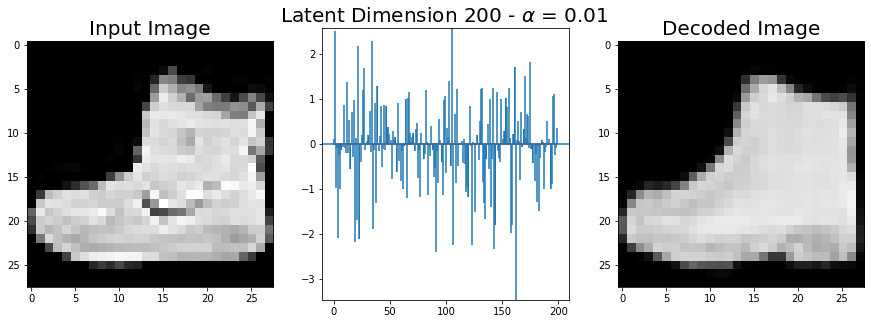

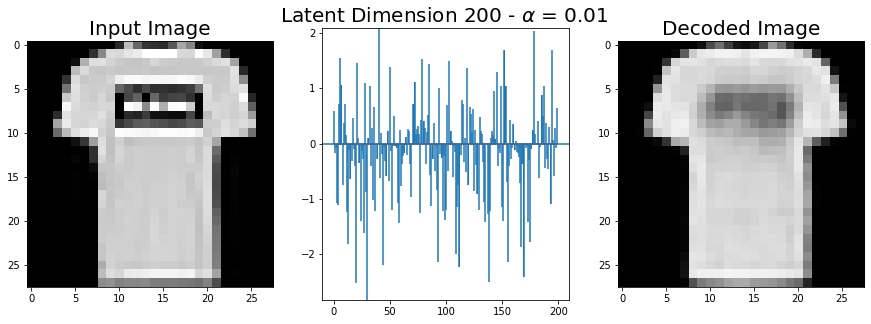

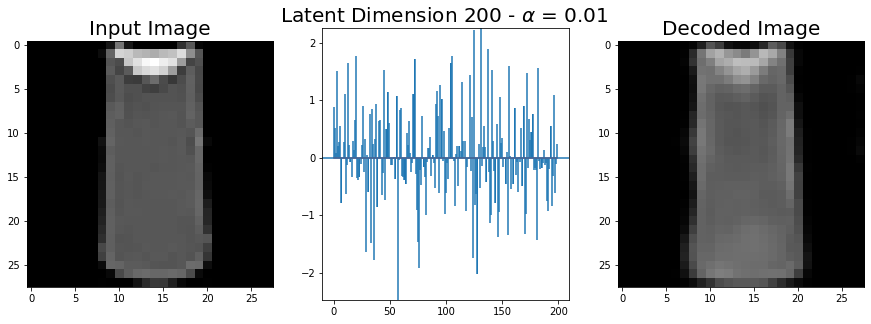

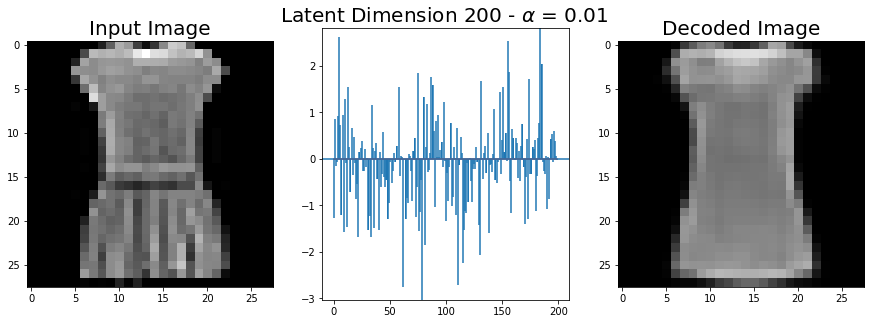

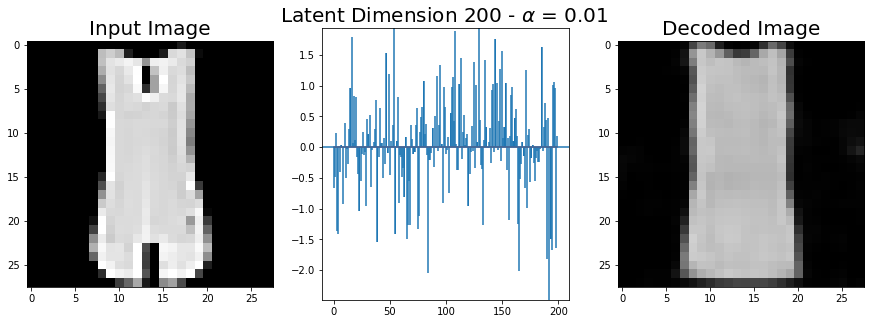

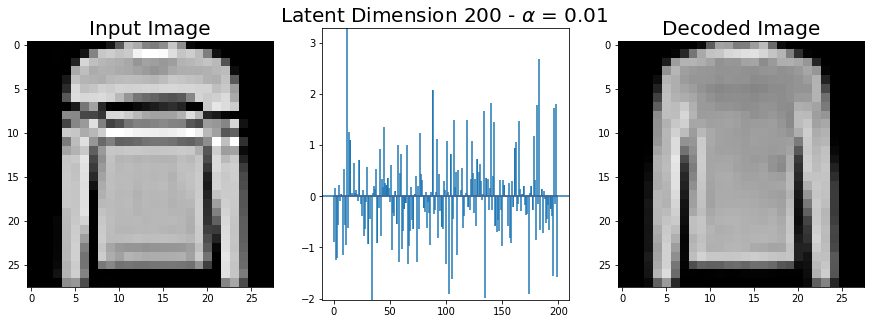

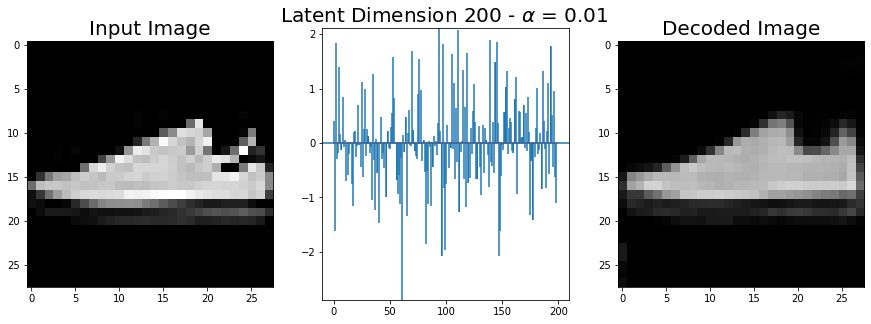

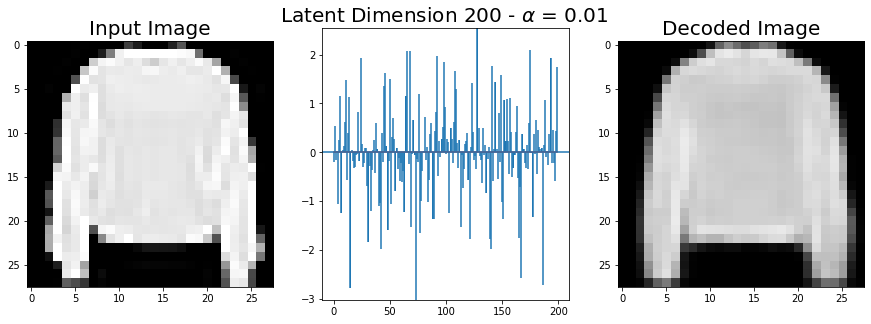

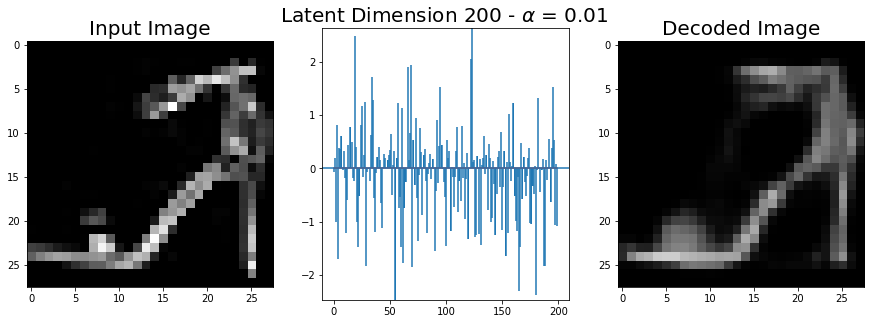

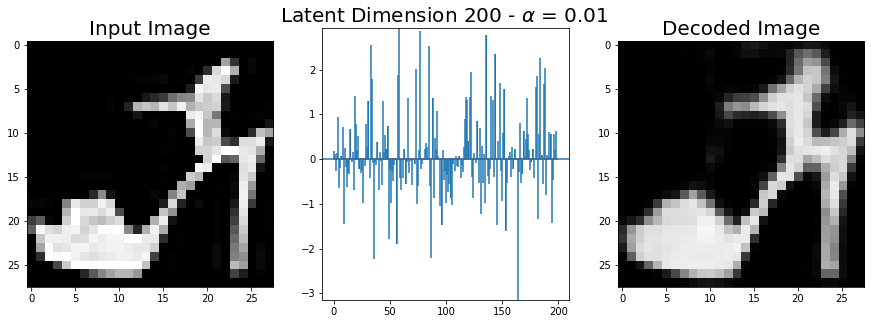

In [8]:
# Plot 10 reconstructed images
for i in range(10):
  plot_reconstruction(image[i], z[i])

In [0]:
def plot_alter_latent(z):
  z_max_index = torch.argmax(torch.abs(z)).cpu()
  fig, ax = plt.subplots(nrows=2, ncols = 3 , figsize=(21,14))

  # Original Latent 
  ax[0, 0].bar(np.arange(z.shape[0]) , height=z.cpu().detach().numpy() , width=0.2)
  ax[0, 0].scatter(np.arange(z.shape[0]) , z.cpu().detach().numpy(), color='blue')
  ax[0, 0].scatter(z_max_index , z[z_max_index].cpu().detach().numpy(), color='red')
  ax[0, 0].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[0], alpha) , fontsize=20)
  ax[0, 0].set_ylim(-torch.abs(z).max().cpu().detach().numpy()-0.1, torch.abs(z).max().cpu().detach().numpy()+0.1)

  img = abpsc.generator(z.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()
  ax[1, 0].imshow(np.transpose(img, (1, 2, 0)))
  ax[1, 0].set_title('Reconstructed Image', fontsize=20)
  # Halved Latent Element
  z_new = z.clone()
  z_new[z_max_index] = z_new[z_max_index] / 2

  ax[0, 1].bar(np.arange(z_new.shape[0]) , height=z_new.cpu().detach().numpy() , width=0.2)
  ax[0, 1].scatter(np.arange(z_new.shape[0]) , z_new.cpu().detach().numpy(), color='blue')
  ax[0, 1].scatter(z_max_index , z_new[z_max_index].cpu().detach().numpy(), color='red')
  ax[0, 1].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z_new.shape[0], alpha) , fontsize=20)
  ax[0, 1].set_ylim(-torch.abs(z).max().cpu().detach().numpy()-0.1, torch.abs(z).max().cpu().detach().numpy()+0.1)

  img = abpsc.generator(z_new.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()  
  ax[1, 1].imshow(np.transpose(img, (1, 2, 0)))
  ax[1, 1].set_title('Reconstructed Image', fontsize=20)

  # Negative Latent Element
  z_new[z_max_index] = z_new[z_max_index] * -1

  ax[0, 2].bar(np.arange(z_new.shape[0]) , height=z_new.cpu().detach().numpy() , width=0.2)
  ax[0, 2].scatter(np.arange(z_new.shape[0]) , z_new.cpu().detach().numpy(), color='blue')
  ax[0, 2].scatter(z_max_index , z_new[z_max_index].cpu().detach().numpy(), color='red')
  ax[0, 2].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z_new.shape[0], alpha) , fontsize=20)
  ax[0, 2].set_ylim(-torch.abs(z).max().cpu().detach().numpy()-0.1, torch.abs(z).max().cpu().detach().numpy()+0.1)

  img = abpsc.generator(z_new.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()  
  ax[1, 2].imshow(np.transpose(img, (1, 2, 0)))
  ax[1, 2].set_title('Reconstructed Image', fontsize=20)

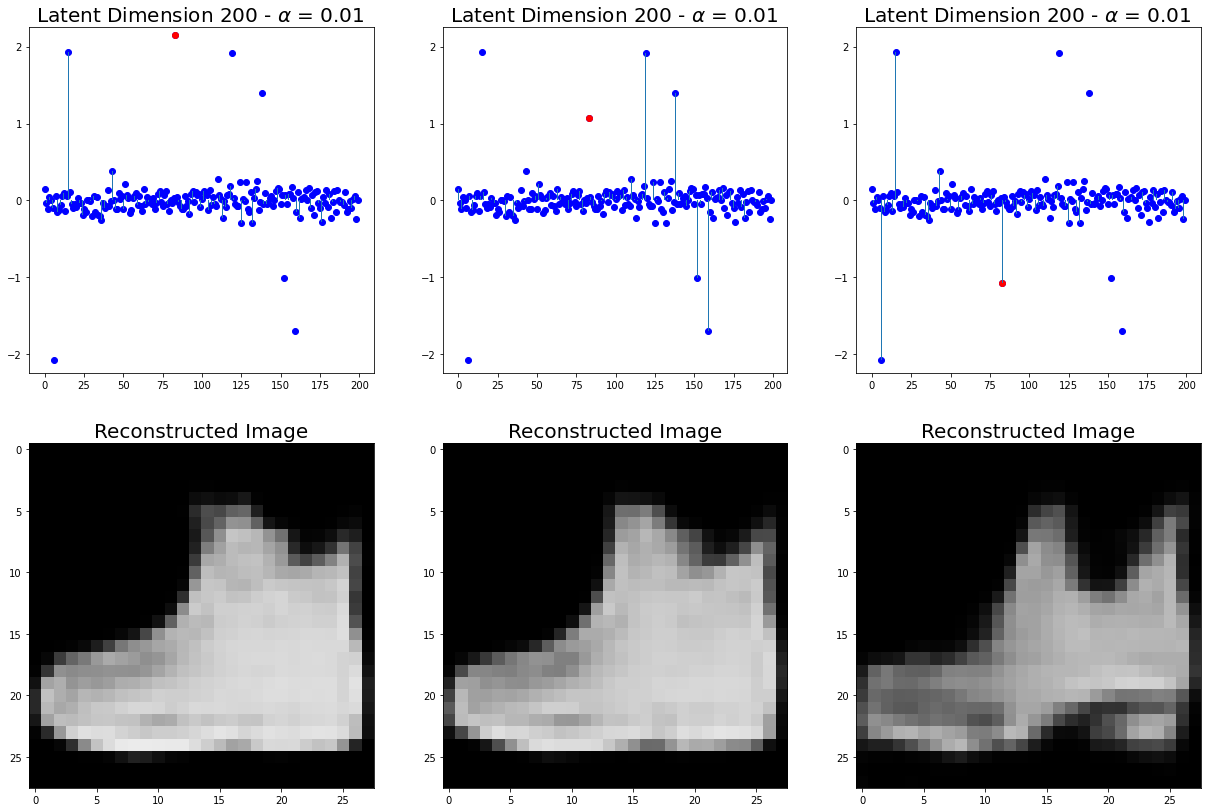

In [0]:
plot_alter_latent(z[0])

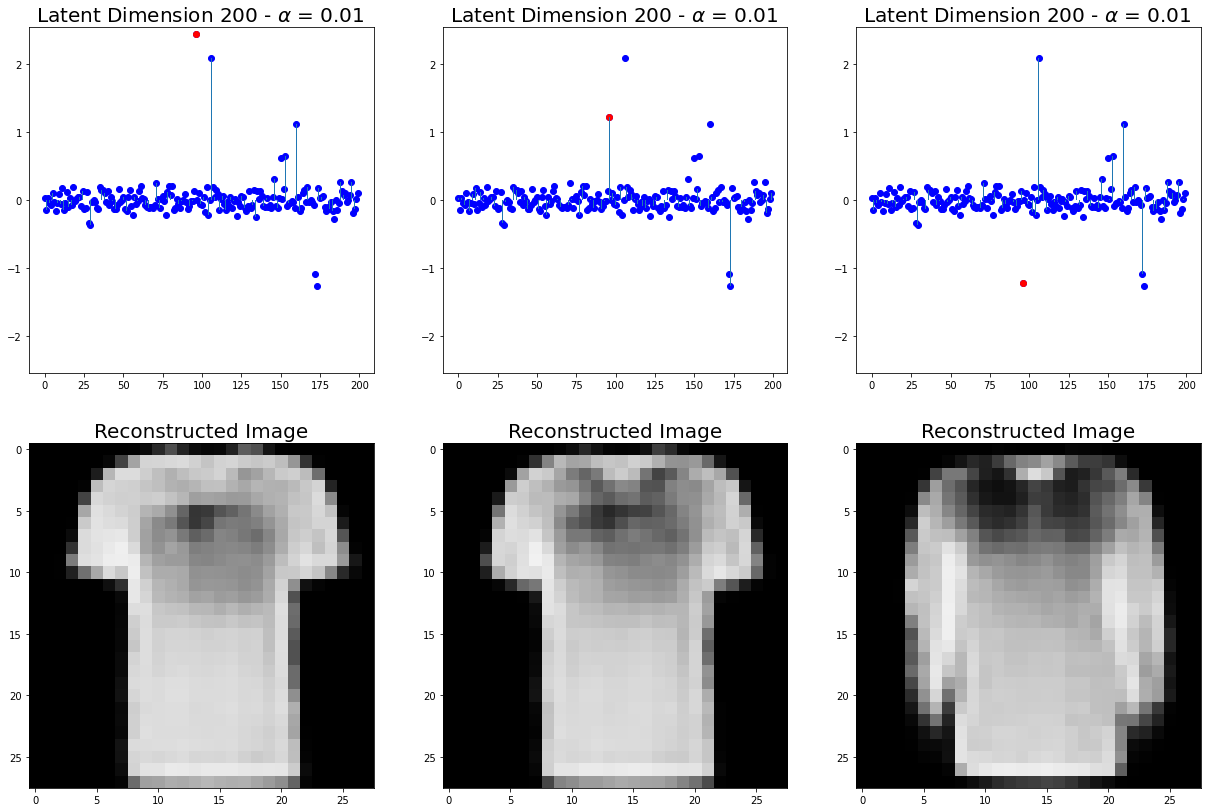

In [0]:
plot_alter_latent(z[1])

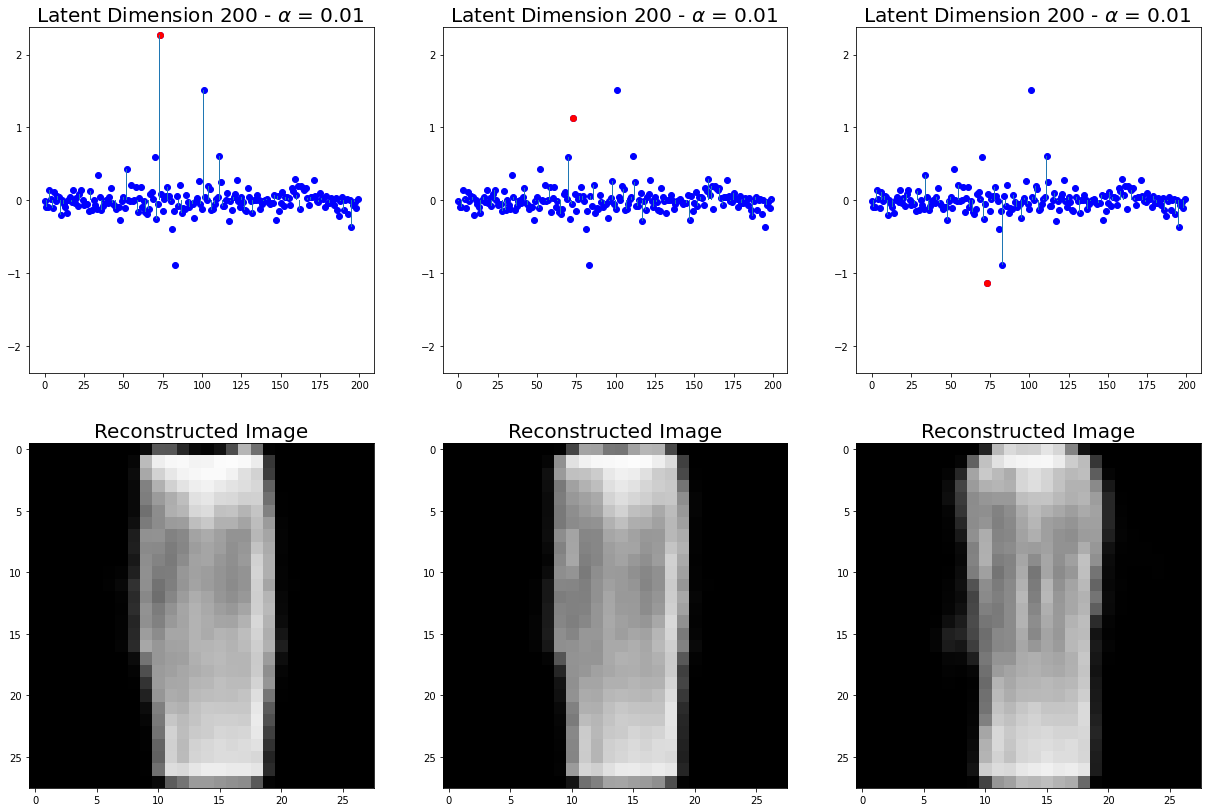

In [0]:
plot_alter_latent(z[2])

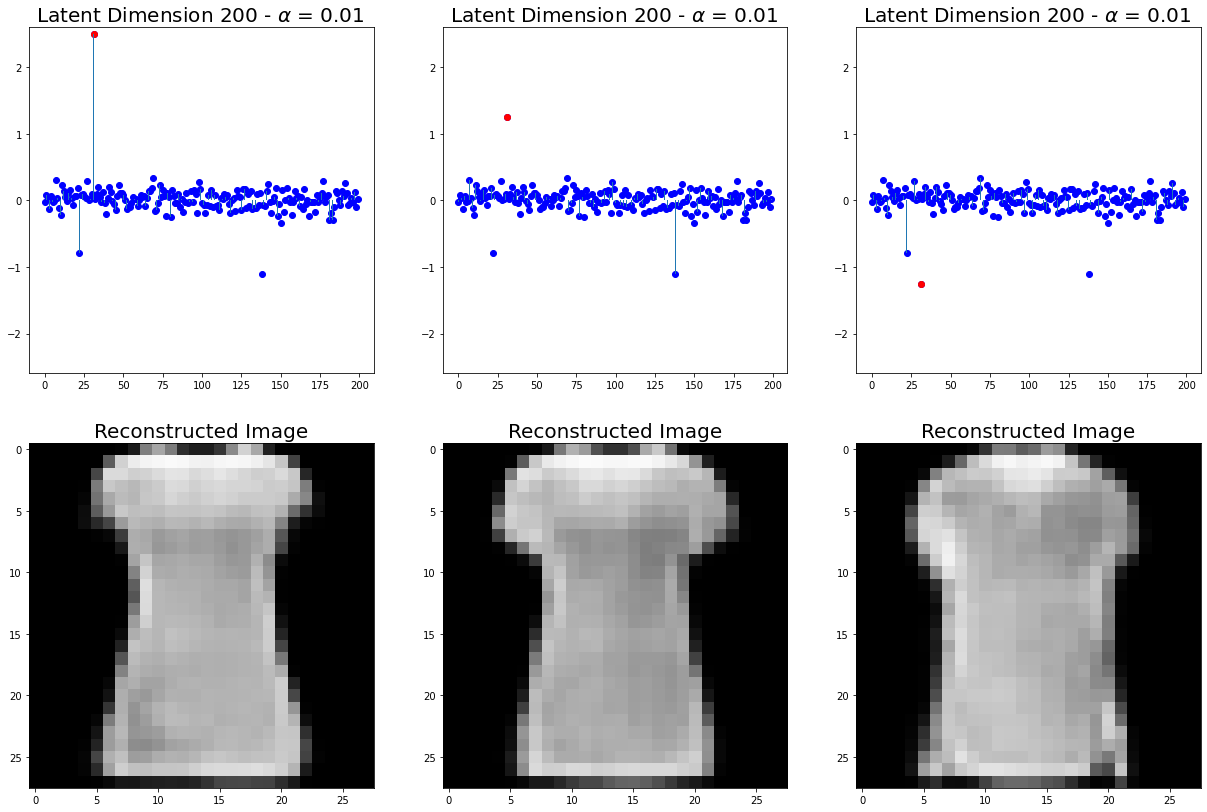

In [0]:
plot_alter_latent(z[3])

In [0]:
def random_sample(generator, latent_size, device, channel_size, image_size, num_samples=64):
  z = torch.randn(num_samples, latent_size).to(device)
  generated = generator(z)
  return generated, z

In [0]:
def plot_generated_single(image, z):
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  img = torchvision.utils.make_grid(image.cpu()).detach().numpy()
  ax0.imshow(np.transpose(img, (1, 2, 0)))
  ax0.set_title('Generated Image')

  ax1.bar(np.arange(z.shape[0]), height=z.cpu().detach().numpy(), width=0.25)
  #ax1.stem(np.arrange(z.shape[1]), z.cpu().detach().numpy()[0], markerfmt=' ', use_line_collection=True)
  #ax1.axhline(y=0)
  ax1.set_title(r"Latent Size: %d - $\alpha$ %.2f " % (z.shape[0], alpha))

In [0]:
# Derivative experiments
import torch
num_epochs = 50
hidden_size = 400
kernel_size = 64

latent_size = 200
alpha = 0.01
learning_rate = 0.001
langevin_steps = 10
noise_variance = 0.3
slab_variance = 0.1
langevin_stepsize = 0.1

In [0]:
z = torch.tensor([-0.04, 0.2, 1.1, 7.1, 15], dtype=torch.float32)
s1 = 1
exp1 = torch.exp(-torch.pow(z, 2) / 2)
exp2 = torch.exp(-torch.pow(z, 2) / 2 / (slab_variance ** 2))
gradient = -(alpha * z * exp1 + (1 - alpha) * z / (slab_variance ** 3) * exp2) / (alpha * exp1 + (1 - alpha) / slab_variance * exp2)
gradient

tensor([  3.9957, -19.8562,  -1.1000,  -7.1000,      nan])

In [0]:
z = torch.tensor([1.3, 2.3, 3.5, 7.1, 15], dtype=torch.float64)
s1 = 1
exp3 = torch.exp(-torch.pow(z, 2) / 2 / (slab_variance ** 2) + torch.pow(z, 2) / 2 / (s1 ** 2))
ratio = (1 - alpha) / alpha

gradient =  z/(s1 ** 2) * (-(1 + ratio * (s1 ** 3) / (slab_variance ** 3) * exp3) / (1 + ratio * s1 / slab_variance + exp3))
gradient

tensor([-0.0013, -0.0023, -0.0035, -0.0072, -0.0151], dtype=torch.float64)

In [0]:
z = torch.tensor([1.3, 2.3, 3.5, 7.1, 15], dtype=torch.float128)
s1 = 1
ratio = (1 - alpha) * s1 / (alpha * slab_variance)
exp4 = torch.exp((slab_variance * slab_variance - s1 * s1) * torch.pow(z, 2) / (2 * s1 * s1 *slab_variance * slab_variance))
gradient = - z / s1 + (ratio * exp4 * (slab_variance * slab_variance - s1 * s1) * z / (s1 * s1 * slab_variance * slab_variance)) / (1 + ratio * exp4)
gradient

In [0]:
exp4

tensor([ 4.6676e-37, 1.8959e-114, 4.5153e-264,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64)

In [0]:
z = torch.tensor([-0.04, 0.2, 1.1, 7.1, 15], dtype=torch.float32)
s1 = 1
ratio1 = (1 - alpha) * s1 / (alpha * slab_variance)
ratio2 = (slab_variance * slab_variance - s1 * s1) / (s1 * s1 * slab_variance * slab_variance)
gradient = - z / (s1 ** 2) + ratio1 * ratio2 * z / (torch.exp(-ratio2 * torch.pow(z, 2) / 2) + ratio1)
gradient

tensor([  3.9957, -19.8562,  -1.1000,  -7.1000, -15.0000])